# Intra-Entity vs Inter-Entity Similarity Analysis

This notebook analyzes the similarity distributions **within** and **between** metabolite entities in the multi-vector index.

**Questions:**
1. **Intra-entity**: For a given metabolite with multiple synonym vectors, how similar are the synonyms to each other?
2. **Inter-entity**: For a fixed vector from one metabolite, how similar is it to vectors from *different* metabolites?

**Hypothesis:** Since the embedding model encodes **text** (not biological identity), synonyms with very different text representations (e.g., common name vs IUPAC name) may not embed similarly. We expect:
- Intra-entity similarities to be moderate (not ~1.0), since synonyms often have very different text
- Inter-entity similarities to match the random pair distribution (~0.32 mean)

In [2]:
import faiss
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
from collections import defaultdict
import torch

# Configuration
INDEX_PATH = Path("../data/indices/full_synonyms/minilm_multi-vector_hnsw_sq8.faiss")
METADATA_PATH = Path("../data/indices/full_synonyms/minilm_multi-vector_hnsw_sq8.metadata.json")

# Check GPU availability
USE_GPU = torch.cuda.is_available()
print(f"GPU available: {USE_GPU}")
if USE_GPU:
    print(f"GPU device: {torch.cuda.get_device_name(0)}")

GPU available: True
GPU device: NVIDIA GeForce RTX 4060 Laptop GPU


## 1. Load Index and Reconstruct Vectors

In [3]:
# Load FAISS index
print(f"Loading index from {INDEX_PATH}...")
index = faiss.read_index(str(INDEX_PATH))
n_vectors = index.ntotal
dim = index.d
print(f"Index loaded: {n_vectors:,} vectors, dimension {dim}")

# Load metadata
print(f"\nLoading metadata from {METADATA_PATH}...")
with open(METADATA_PATH, 'r') as f:
    metadata = json.load(f)
print(f"Metadata loaded: {len(metadata):,} entries")

# Show sample metadata entry
print(f"\nSample metadata entry:")
print(f"  Key '0': {metadata['0']}")

Loading index from ../data/indices/full_synonyms/minilm_multi-vector_hnsw_sq8.faiss...
Index loaded: 1,749,141 vectors, dimension 384

Loading metadata from ../data/indices/full_synonyms/minilm_multi-vector_hnsw_sq8.metadata.json...
Metadata loaded: 1,749,141 entries

Sample metadata entry:
  Key '0': {'hmdb_id': 'HMDB0000001', 'tier': 'primary', 'weight': 1.0, 'text': '1-Methylhistidine'}


In [4]:
# Reconstruct vectors from the index (batch mode for performance)
print("Reconstructing vectors from index (batch mode)...")
vectors = np.zeros((n_vectors, dim), dtype=np.float32)
index.reconstruct_n(0, n_vectors, vectors)

# Normalize vectors (should already be normalized, but ensure)
norms = np.linalg.norm(vectors, axis=1, keepdims=True)
vectors = vectors / np.clip(norms, 1e-8, None)

print(f"Vectors reconstructed: shape {vectors.shape}")

Reconstructing vectors from index (batch mode)...
Vectors reconstructed: shape (1749141, 384)


## 2. Group Vectors by Metabolite Entity (HMDB ID)

In [5]:
# Build mapping: hmdb_id -> [vector_indices]
entity_to_indices = defaultdict(list)

for idx_str, entry in metadata.items():
    hmdb_id = entry['hmdb_id']
    vector_idx = int(idx_str)
    entity_to_indices[hmdb_id].append(vector_idx)

# Convert to regular dict and sort indices within each group
entity_to_indices = {k: sorted(v) for k, v in entity_to_indices.items()}

print(f"Total entities (unique HMDB IDs): {len(entity_to_indices):,}")

# Analyze synonym count distribution
synonym_counts = [len(indices) for indices in entity_to_indices.values()]
print(f"\nSynonyms per entity:")
print(f"  Mean: {np.mean(synonym_counts):.2f}")
print(f"  Median: {np.median(synonym_counts):.1f}")
print(f"  Min: {np.min(synonym_counts)}")
print(f"  Max: {np.max(synonym_counts)}")
print(f"  Entities with >=2 synonyms: {sum(1 for c in synonym_counts if c >= 2):,}")

# Show example
example_hmdb = list(entity_to_indices.keys())[0]
example_indices = entity_to_indices[example_hmdb]
print(f"\nExample: {example_hmdb} has {len(example_indices)} vectors")
for idx in example_indices[:5]:
    print(f"  [{idx}]: {metadata[str(idx)]['text']} (tier: {metadata[str(idx)]['tier']})")
if len(example_indices) > 5:
    print(f"  ... and {len(example_indices) - 5} more")

Total entities (unique HMDB IDs): 217,920

Synonyms per entity:
  Mean: 8.03
  Median: 4.0
  Min: 1
  Max: 637
  Entities with >=2 synonyms: 216,861

Example: HMDB0000001 has 13 vectors
  [0]: 1-Methylhistidine (tier: primary)
  [1]: (2S)-2-Amino-3-(1-methyl-1H-imidazol-4-yl)propanoic acid (tier: synonym)
  [2]: Pi-methylhistidine (tier: synonym)
  [3]: (2S)-2-Amino-3-(1-methyl-1H-imidazol-4-yl)propanoate (tier: synonym)
  [4]: 1 Methylhistidine (tier: synonym)
  ... and 8 more


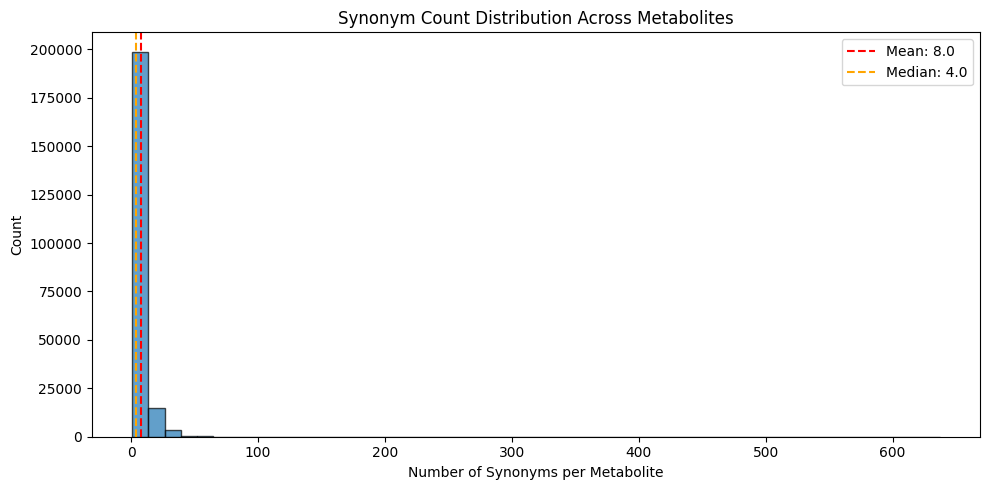

In [6]:
# Plot synonym count distribution
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(synonym_counts, bins=50, edgecolor='black', alpha=0.7)
ax.axvline(np.mean(synonym_counts), color='red', linestyle='--', label=f'Mean: {np.mean(synonym_counts):.1f}')
ax.axvline(np.median(synonym_counts), color='orange', linestyle='--', label=f'Median: {np.median(synonym_counts):.1f}')
ax.set_xlabel('Number of Synonyms per Metabolite')
ax.set_ylabel('Count')
ax.set_title('Synonym Count Distribution Across Metabolites')
ax.legend()
plt.tight_layout()
plt.show()

## 3. Intra-Entity Similarity Analysis

For metabolites with multiple synonyms, compute pairwise cosine similarities **within** each synonym group.

In [7]:
# Sample metabolites with at least 2 synonyms
N_SAMPLE_ENTITIES = 1000

# Get entities with >= 2 synonyms
multi_synonym_entities = [hmdb_id for hmdb_id, indices in entity_to_indices.items() if len(indices) >= 2]
print(f"Entities with >=2 synonyms: {len(multi_synonym_entities):,}")

# Sample
np.random.seed(42)
sampled_entities = np.random.choice(multi_synonym_entities, size=min(N_SAMPLE_ENTITIES, len(multi_synonym_entities)), replace=False)
print(f"Sampled {len(sampled_entities)} entities for analysis")

Entities with >=2 synonyms: 216,861
Sampled 1000 entities for analysis


In [8]:
# Compute intra-entity similarities
intra_similarities = []

print("Computing intra-entity similarities...")
for i, hmdb_id in enumerate(sampled_entities):
    indices = entity_to_indices[hmdb_id]
    n_synonyms = len(indices)
    
    # Get all synonym vectors for this entity
    entity_vectors = vectors[indices]  # shape: (n_synonyms, dim)
    
    # Compute all pairwise similarities within this entity
    # Using matrix multiplication: similarity_matrix[i,j] = dot(v_i, v_j)
    if USE_GPU:
        entity_vectors_gpu = torch.tensor(entity_vectors, device='cuda')
        sim_matrix = torch.mm(entity_vectors_gpu, entity_vectors_gpu.T).cpu().numpy()
    else:
        sim_matrix = entity_vectors @ entity_vectors.T
    
    # Extract upper triangle (excluding diagonal - no self-similarities)
    upper_tri_indices = np.triu_indices(n_synonyms, k=1)
    pairwise_sims = sim_matrix[upper_tri_indices]
    intra_similarities.extend(pairwise_sims)
    
    if (i + 1) % 200 == 0:
        print(f"  Processed {i + 1}/{len(sampled_entities)} entities")

intra_similarities = np.array(intra_similarities)
print(f"\nTotal intra-entity similarity pairs: {len(intra_similarities):,}")
print(f"Mean: {intra_similarities.mean():.4f}")
print(f"Std: {intra_similarities.std():.4f}")
print(f"Min: {intra_similarities.min():.4f}")
print(f"Max: {intra_similarities.max():.4f}")

Computing intra-entity similarities...
  Processed 200/1000 entities
  Processed 400/1000 entities


  Processed 600/1000 entities
  Processed 800/1000 entities
  Processed 1000/1000 entities

Total intra-entity similarity pairs: 50,546
Mean: 0.4432
Std: 0.2706
Min: -0.0761
Max: 1.0000


## 4. Inter-Entity Similarity Analysis

For each sampled metabolite, compute similarity between one of its vectors and vectors from **different** metabolites.

In [9]:
# For inter-entity: pick one vector per sampled entity, compare to vectors from OTHER entities
N_OTHER_VECTORS = 100  # Number of vectors from other entities to compare against

inter_similarities = []

# Build a set of all vector indices for fast lookup
all_indices = np.arange(n_vectors)

print(f"Computing inter-entity similarities ({len(sampled_entities)} entities x {N_OTHER_VECTORS} others)...")

np.random.seed(43)
for i, hmdb_id in enumerate(sampled_entities):
    # Get indices for this entity
    entity_indices = set(entity_to_indices[hmdb_id])
    
    # Pick the primary vector (first one, usually the primary name)
    anchor_idx = entity_to_indices[hmdb_id][0]
    anchor_vector = vectors[anchor_idx]
    
    # Sample vectors from OTHER entities (exclude all vectors from this entity)
    other_indices = np.array([idx for idx in all_indices if idx not in entity_indices])
    sampled_other_indices = np.random.choice(other_indices, size=N_OTHER_VECTORS, replace=False)
    
    # Compute similarities
    if USE_GPU:
        anchor_gpu = torch.tensor(anchor_vector, device='cuda').unsqueeze(0)
        others_gpu = torch.tensor(vectors[sampled_other_indices], device='cuda')
        sims = torch.mm(anchor_gpu, others_gpu.T).squeeze().cpu().numpy()
    else:
        sims = vectors[sampled_other_indices] @ anchor_vector
    
    inter_similarities.extend(sims)
    
    if (i + 1) % 200 == 0:
        print(f"  Processed {i + 1}/{len(sampled_entities)} entities")

inter_similarities = np.array(inter_similarities)
print(f"\nTotal inter-entity similarity pairs: {len(inter_similarities):,}")
print(f"Mean: {inter_similarities.mean():.4f}")
print(f"Std: {inter_similarities.std():.4f}")
print(f"Min: {inter_similarities.min():.4f}")
print(f"Max: {inter_similarities.max():.4f}")

Computing inter-entity similarities (1000 entities x 100 others)...
  Processed 200/1000 entities
  Processed 400/1000 entities
  Processed 600/1000 entities
  Processed 800/1000 entities
  Processed 1000/1000 entities

Total inter-entity similarity pairs: 100,000
Mean: 0.2723
Std: 0.1903
Min: -0.1282
Max: 0.9951


## 5. Visualization: Intra vs Inter-Entity Distributions

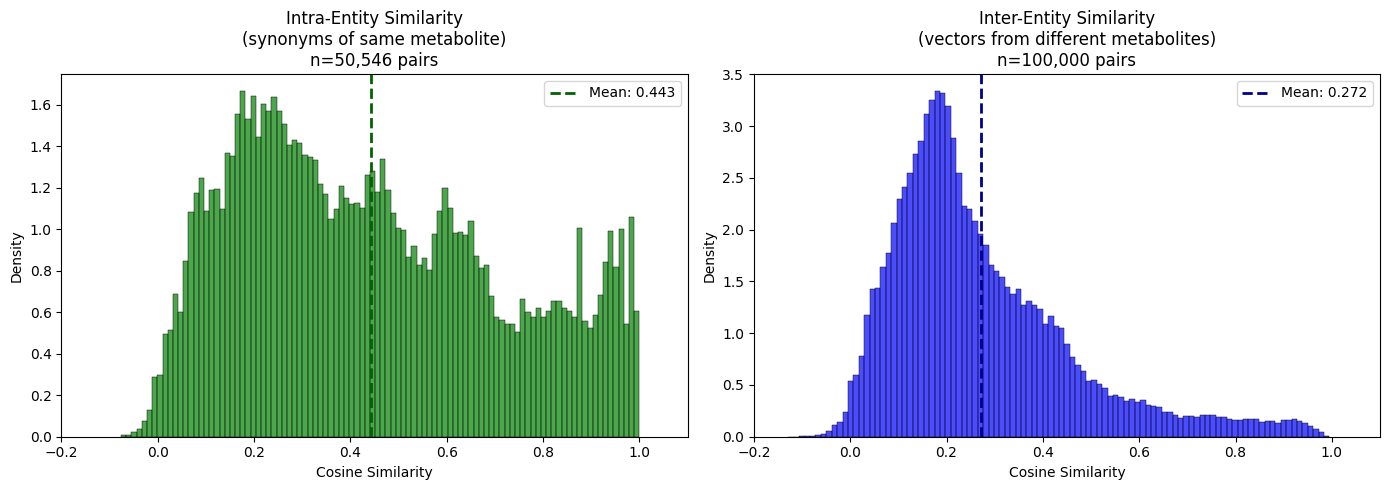

In [10]:
# Side-by-side histograms
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Intra-entity distribution
ax = axes[0]
sns.histplot(intra_similarities, bins=100, ax=ax, stat='density', color='green', alpha=0.7)
ax.axvline(intra_similarities.mean(), color='darkgreen', linestyle='--', linewidth=2,
           label=f'Mean: {intra_similarities.mean():.3f}')
ax.set_xlabel('Cosine Similarity')
ax.set_ylabel('Density')
ax.set_title(f'Intra-Entity Similarity\n(synonyms of same metabolite)\nn={len(intra_similarities):,} pairs')
ax.set_xlim(-0.2, 1.1)
ax.legend()

# Inter-entity distribution
ax = axes[1]
sns.histplot(inter_similarities, bins=100, ax=ax, stat='density', color='blue', alpha=0.7)
ax.axvline(inter_similarities.mean(), color='darkblue', linestyle='--', linewidth=2,
           label=f'Mean: {inter_similarities.mean():.3f}')
ax.set_xlabel('Cosine Similarity')
ax.set_ylabel('Density')
ax.set_title(f'Inter-Entity Similarity\n(vectors from different metabolites)\nn={len(inter_similarities):,} pairs')
ax.set_xlim(-0.2, 1.1)
ax.legend()

plt.tight_layout()
plt.show()

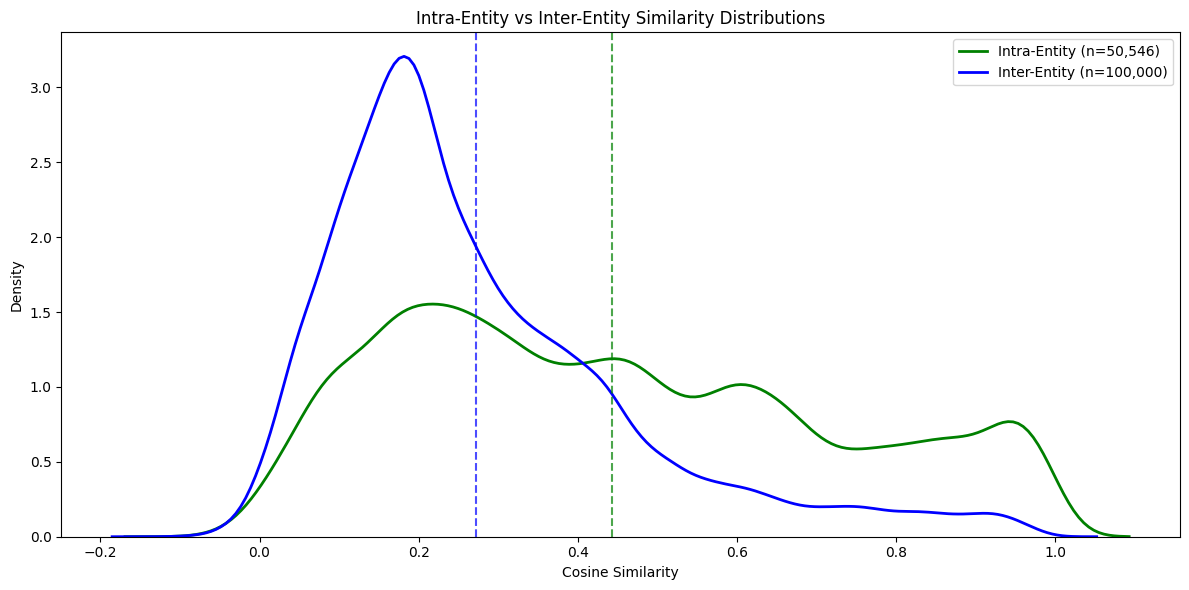

In [11]:
# Overlaid KDE plot
fig, ax = plt.subplots(figsize=(12, 6))

sns.kdeplot(intra_similarities, ax=ax, label=f'Intra-Entity (n={len(intra_similarities):,})', 
            linewidth=2, color='green')
sns.kdeplot(inter_similarities, ax=ax, label=f'Inter-Entity (n={len(inter_similarities):,})', 
            linewidth=2, color='blue')

ax.axvline(intra_similarities.mean(), color='green', linestyle='--', alpha=0.7)
ax.axvline(inter_similarities.mean(), color='blue', linestyle='--', alpha=0.7)

ax.set_xlabel('Cosine Similarity')
ax.set_ylabel('Density')
ax.set_title('Intra-Entity vs Inter-Entity Similarity Distributions')
ax.legend()

plt.tight_layout()
plt.show()

## 6. Statistical Summary

In [12]:
import pandas as pd

# Summary table
summary = pd.DataFrame({
    'Metric': ['Count', 'Mean', 'Median', 'Std', 'Min', 'Max', '% >= 0.9', '% >= 0.99', '% >= 0.999'],
    'Intra-Entity': [
        f"{len(intra_similarities):,}",
        f"{intra_similarities.mean():.4f}",
        f"{np.median(intra_similarities):.4f}",
        f"{intra_similarities.std():.4f}",
        f"{intra_similarities.min():.4f}",
        f"{intra_similarities.max():.4f}",
        f"{100*np.sum(intra_similarities >= 0.9)/len(intra_similarities):.2f}%",
        f"{100*np.sum(intra_similarities >= 0.99)/len(intra_similarities):.2f}%",
        f"{100*np.sum(intra_similarities >= 0.999)/len(intra_similarities):.2f}%"
    ],
    'Inter-Entity': [
        f"{len(inter_similarities):,}",
        f"{inter_similarities.mean():.4f}",
        f"{np.median(inter_similarities):.4f}",
        f"{inter_similarities.std():.4f}",
        f"{inter_similarities.min():.4f}",
        f"{inter_similarities.max():.4f}",
        f"{100*np.sum(inter_similarities >= 0.9)/len(inter_similarities):.2f}%",
        f"{100*np.sum(inter_similarities >= 0.99)/len(inter_similarities):.2f}%",
        f"{100*np.sum(inter_similarities >= 0.999)/len(inter_similarities):.2f}%"
    ]
})

print("="*60)
print("SUMMARY: Intra-Entity vs Inter-Entity Similarity")
print("="*60)
print(summary.to_string(index=False))

# Entity discriminability gap
entity_gap = intra_similarities.mean() - inter_similarities.mean()
print(f"\n" + "="*60)
print(f"ENTITY DISCRIMINABILITY GAP: {entity_gap:.4f}")
print(f"  Intra-entity mean: {intra_similarities.mean():.4f}")
print(f"  Inter-entity mean: {inter_similarities.mean():.4f}")
print(f"  Gap (intra - inter): {entity_gap:.4f}")

SUMMARY: Intra-Entity vs Inter-Entity Similarity
    Metric Intra-Entity Inter-Entity
     Count       50,546      100,000
      Mean       0.4432       0.2723
    Median       0.4045       0.2220
       Std       0.2706       0.1903
       Min      -0.0761      -0.1282
       Max       1.0000       0.9951
  % >= 0.9        7.86%        1.05%
 % >= 0.99        0.56%        0.00%
% >= 0.999        0.02%        0.00%

ENTITY DISCRIMINABILITY GAP: 0.1709
  Intra-entity mean: 0.4432
  Inter-entity mean: 0.2723
  Gap (intra - inter): 0.1709


## 7. Validation and Conclusions

In [13]:
# Analysis and conclusions
print("="*60)
print("ANALYSIS")
print("="*60)

intra_mean = intra_similarities.mean()
inter_mean = inter_similarities.mean()

# Check 1: Inter-entity matches random pair distribution
if 0.25 < inter_mean < 0.40:
    print(f"[OK] Inter-entity mean ({inter_mean:.3f}) matches random pair distribution (~0.32)")
else:
    print(f"[NOTE] Inter-entity mean ({inter_mean:.3f}) differs from random pairs (~0.32)")

# Check 2: Intra-entity is higher than inter-entity (as expected)
if intra_mean > inter_mean:
    print(f"[OK] Intra-entity mean ({intra_mean:.3f}) > inter-entity mean ({inter_mean:.3f})")
else:
    print(f"[UNEXPECTED] Intra-entity mean ({intra_mean:.3f}) <= inter-entity mean")

print("\n" + "="*60)
print("CONCLUSIONS")
print("="*60)
print(f"""
1. KEY FINDING: Synonyms of the same metabolite have only MODERATE similarity
   (mean ~{intra_mean:.2f}), not the ~1.0 one might naively expect.
   
   This is because the embedding model encodes TEXT, not biological identity.
   For example, "1-Methylhistidine" and its IUPAC name 
   "(2S)-2-Amino-3-(1-methyl-1H-imidazol-4-yl)propanoic acid" are the same 
   metabolite but have very different text, so they embed differently.

2. Inter-entity similarity (mean ~{inter_mean:.2f}) matches the random pair
   distribution (~0.32), as expected. Different metabolites are not more
   similar to each other than random pairs.

3. The discriminability gap ({entity_gap:.2f}) is relatively small. This has
   important implications for search:
   
   - You CANNOT rely on embedding similarity alone to find all synonyms
   - The multi-vector strategy is essential: explicitly index all synonyms
   - This justifies the ~8 vectors per metabolite in the multi-vector approach
   
4. Why does NN analysis show mean ~0.94? The nearest neighbor of any vector
   is often a near-duplicate (e.g., "N-methylhistidine" vs "N-Methylhistidine")
   - minor text variations that embed almost identically. These are typically
   "variation" tier vectors, not arbitrary synonyms.

5. VALIDATION: The multi-vector approach is NECESSARY because text-based
   embeddings don't naturally cluster synonyms together. By explicitly indexing
   all synonyms, we ensure that queries find the metabolite regardless of which
   name variant the user searches for.
""")

ANALYSIS
[OK] Inter-entity mean (0.272) matches random pair distribution (~0.32)
[OK] Intra-entity mean (0.443) > inter-entity mean (0.272)

CONCLUSIONS

1. KEY FINDING: Synonyms of the same metabolite have only MODERATE similarity
   (mean ~0.44), not the ~1.0 one might naively expect.

   This is because the embedding model encodes TEXT, not biological identity.
   For example, "1-Methylhistidine" and its IUPAC name 
   "(2S)-2-Amino-3-(1-methyl-1H-imidazol-4-yl)propanoic acid" are the same 
   metabolite but have very different text, so they embed differently.

2. Inter-entity similarity (mean ~0.27) matches the random pair
   distribution (~0.32), as expected. Different metabolites are not more
   similar to each other than random pairs.

3. The discriminability gap (0.17) is relatively small. This has
   important implications for search:

   - You CANNOT rely on embedding similarity alone to find all synonyms
   - The multi-vector strategy is essential: explicitly index all synon